# Adverserial Variational Optimization

*Gilles Louppe & Kayle Cranmer*

Notebook by Joeri Hermans

In [1]:
!date

Thu Oct 12 22:43:03 CEST 2017


Complex computer simulators are increasingly used across fields of science as generative models tying parameters of an underlying theory to experimental observations. Inference in this setup is often difficult, as simulators rarely admit a tractable density or likelihood function. We introduce Adversarial Variational Optimization (AVO), a likelihood-free inference algorithm for fitting a non-differentiable generative model incorporating ideas from empirical Bayes and variational inference. We adapt the training procedure of generative adversarial networks by replacing the differentiable generative network with a domain-specific simulator. We solve the resulting non-differentiable minimax problem by minimizing variational upper bounds of the two adversarial objectives. Effectively, the procedure results in learning a proposal distribution over simulator parameters, such that the corresponding marginal distribution of the generated data matches the observations. We present results of the method with simulators producing both discrete and continuous data.

**Manuscript**: [https://arxiv.org/abs/1707.07113](https://arxiv.org/abs/1707.07113)

## Configuration

### Imports

In [2]:
import numpy as np
import torch
import math
import matplotlib.mlab as mlab
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm as sp_norm

from sklearn.utils import check_random_state

### Globals

In [3]:
seed = 1337
random_number_generator = check_random_state(seed)

batch_size = 64
num_epochs = 300

beam_energy = 45.0 # In GeV
fermi_constant = 0.9

theta_true = np.array([beam_energy, fermi_constant])

### Utility Methods

In [4]:
def plot_observations(X_observed, theta_optimal):
    plt.grid(True)
    plt.hist(X_observed, histtype="bar", range=(-1, 1), bins=100)
    plt.xlim([-1, 1])
    plt.ylim([0, 3000])
    plt.title(r"Distribution of $\cos(A)$ in $e^-e^+ \rightarrow \mu^-\mu^+$ events." + "\n"
              r"$E_{beam}}$ = " + str(theta_optimal[0]) + "GeV   -   " + r"$G_f$ = " + str(theta_optimal[1]))
    plt.xlabel(r"$\cos(A)$")
    plt.ylabel("Events")
    plt.show()
    
def random_gaussian(mu=[-1, 1], sigma=5.0):
    return {'mu': np.random.uniform(mu[0], mu[1]),
            'sigma': np.random.uniform(0.0, sigma)}

## Introduction

TODO Explain goals.

## Problem Statement

TODO

## Simulator

This notebook will only consider a simplified simulator from particle physics for electron-positron ($e^-e^+$) collisions resulting in muon-antipuon pairs ($\mu^-\mu^+$), i.e., $e^-e^+ \rightarrow \mu^-\mu^+$. The simulator approximates the distribution of observed measurements $\mathbf{x} = \cos(A) \in [-1, 1]$, where $A$ is the polar angle of the center of mass momenta of the outgoing muon with respect to the originally incoming electron. When we neglect the measurement uncertainty induced fromt he particle detectors, this random variable is approximately distributed as:

**Additional information**: [Positron - Electron Annihilation into Muon - Anti-muon](http://geant4.cern.ch/G4UsersDocuments/UsersGuides/PhysicsReferenceManual/html/node44.html)

In [5]:
def simulator(theta, n_samples, random_state=None):
    rng = check_random_state(random_state)
    samples = rej_sample_costheta(n_samples, theta, rng)

    return samples.reshape(-1, 1)

def rej_sample_costheta(n_samples, theta, rng):
    #sqrtshalf = theta[0] * (50 - 40) + 40
    #gf = theta[1] * (1.5 - 0.5) + 0.5
    sqrtshalf = theta[0]
    gf = theta[1]
    
    ntrials = 0
    samples = []
    x = np.linspace(-1, 1, num=1000)
    maxval = np.max(diffxsec(x, sqrtshalf, gf))

    while len(samples) < n_samples:
        ntrials = ntrials + 1
        xprop = rng.uniform(-1, 1)
        ycut = rng.rand()
        yprop = diffxsec(xprop, sqrtshalf, gf) / maxval
        if (yprop / maxval) < ycut:
            continue
        samples.append(xprop)

    return np.array(samples)

def diffxsec(costheta, sqrtshalf, gf):
    norm = 2. * (1. + 1. / 3.)
    return ((1 + costheta ** 2) + a_fb(sqrtshalf, gf) * costheta) / norm

def a_fb(sqrtshalf, gf):
    mz = 90
    gf_nom = 0.9
    sqrts = sqrtshalf * 2.
    a_fb_en = np.tanh((sqrts - mz) / mz * 10)
    a_fb_gf = gf / gf_nom

    return 2 * a_fb_en * a_fb_gf

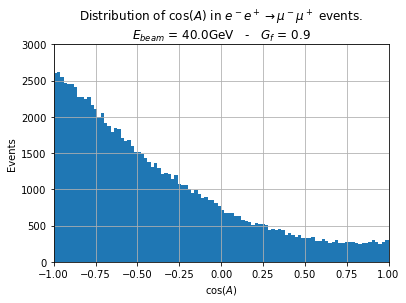

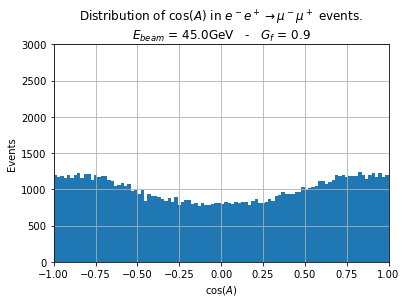

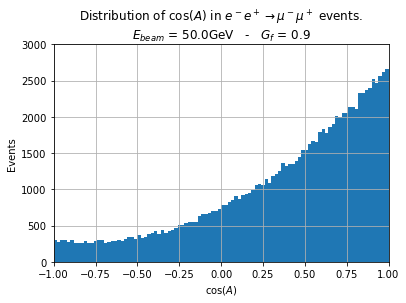

In [6]:
# Show the different distributions of cos(A) for different beam energies.
for energy in range(40, 51, 5):
    theta = np.array([energy, fermi_constant])
    X_observed = simulator(theta, 100000, random_state=random_number_generator)
    plot_observations(X_observed, theta)

## Model

In this section we describe the adverserial model we'll be training to fit the adverserial objective.

In [7]:
class Critic(torch.nn.Module):
    
    def __init__(self, num_features, num_hidden):
        super(Critic, self).__init__()
        self.fc_1 = t.nn.Linear(num_features, num_hidden)
        self.fc_2 = t.nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        
        return x

In [8]:
def make_gaussian_proposal(n_parameters, mu=0.0, log_sigma=0.0):
    return {"mu":  mu * np.ones(n_parameters),
            "log_sigma": log_sigma * np.ones(n_parameters)}


def gaussian_draw(params, n_samples, random_state=None):
    n_parameters = len(params["mu"])
    mu = params["mu"]
    sigma = np.exp(params["log_sigma"])

    thetas = np.zeros((n_samples, n_parameters))

    for i in range(n_parameters):
        thetas[:, i] = sp_norm.rvs(size=n_samples,
                                   loc=mu[i],
                                   scale=sigma[i],
                                   random_state=random_state)

    return thetas

In [9]:
X_observed = simulator(theta_true, 100000, random_state=random_number_generator)
num_features = X_observed.shape[1]
num_parameters = len(theta_true)
m = 64

params = make_gaussian_proposal(num_parameters, mu=0.5, log_sigma=np.log(0.1))
thetas = gaussian_draw(params, m // 2, random_state=random_number_generator)

y_critic = np.zeros(m)
y_critic[batch_size // 2:] = 1.0
_X_gen = np.zeros((batch_size // 2, num_features))

for j, theta in enumerate(thetas):
    _X_gen[j, :] = simulator(theta, 1, random_state=random_number_generator).ravel()

indices = random_number_generator.permutation(len(X_observed))
_X_obs = X_observed[indices[:batch_size // 2]]
X = np.vstack([_X_gen, _X_obs])

### Experimental Data

Before any inference can be done on our parameters of interest, i.e., the beam energy, $E_{beam}$, and Fermi's constant, $G_f$.

### Prior Initialization

In [42]:
# Initialize prior of p(theta | phi).
p_theta_phi = {'mu': [], 'sigma': []}

# Sample a random Gaussian for the beam energy.
g = random_gaussian(mu=[30, 60], sigma=1.0)
p_theta_phi['mu'].append(g['mu'])
p_theta_phi['sigma'].append(g['sigma'])

# Sample a random Gaussian for Fermi's paradox.
g = random_gaussian(mu=[0, 2], sigma=1.0)
p_theta_phi['mu'].append(g['mu'])
p_theta_phi['sigma'].append(g['sigma'])

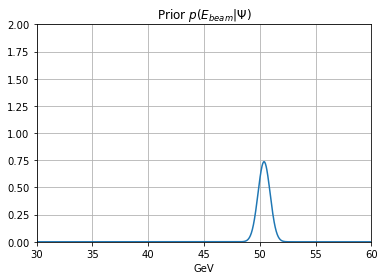

In [43]:
# Obtain the parameterization of the beam energy prior.
prior_beam_energy_mu = p_theta_phi['mu'][0]
prior_beam_energy_sigma = p_theta_phi['sigma'][0]
prior_beam_energy_variance = prior_beam_energy_sigma ** 2

# Draw the prior over the beam enery.
x = np.linspace(30, 60, 1000)
plt.plot(x, mlab.normpdf(x, prior_beam_energy_mu, prior_beam_energy_sigma))
plt.xlim([30, 60])
plt.ylim([0, 2])
plt.xlabel("GeV")
plt.grid(True)
plt.title(r"Prior $p(E_{beam}|\Psi)$")
plt.show()

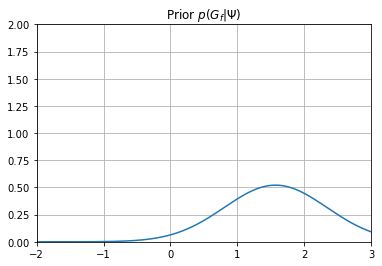

In [44]:
# Obtain the parameterization of Fermi's constant prior.
prior_gf_mu = p_theta_phi['mu'][1]
prior_gf_sigma = p_theta_phi['sigma'][1]
prior_gf_variance = prior_gf_sigma ** 2

# Draw the prior over the beam enery.
x = np.linspace(-2, 3, 1000)
plt.plot(x, mlab.normpdf(x, prior_gf_mu, prior_gf_sigma))
plt.xlim([-2, 3])
plt.ylim([0, 2])
plt.grid(True)
plt.title(r"Prior $p(G_f|\Psi)$")
plt.show()

## Conclusion